# Analyzing LAPD Crime Stats

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time


In [2]:
# importing the dataset
crimes_lapd = pd.read_csv("./crimes.csv")
crimes_lapd.head(2)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,220314085,2022-07-22,2020-05-12,1110,Southwest,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,222013040,2022-08-06,2020-06-04,1620,Olympic,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST


In [3]:
crimes_lapd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185715 entries, 0 to 185714
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   DR_NO         185715 non-null  int64 
 1   Date Rptd     185715 non-null  object
 2   DATE OCC      185715 non-null  object
 3   TIME OCC      185715 non-null  int64 
 4   AREA NAME     185715 non-null  object
 5   Crm Cd Desc   185715 non-null  object
 6   Vict Age      185715 non-null  int64 
 7   Vict Sex      185704 non-null  object
 8   Vict Descent  185705 non-null  object
 9   Weapon Desc   73502 non-null   object
 10  Status Desc   185715 non-null  object
 11  LOCATION      185715 non-null  object
dtypes: int64(3), object(9)
memory usage: 17.0+ MB


Based on 1st run , making changes to the dataframe to account for morning values in the TIME OCC column

### Re-formatting Time OCC with zero-padding

In [4]:
crimes_lapd["TIME OCC"] = crimes_lapd["TIME OCC"].astype("str")

Adding leading zeros to the string where string length is less than 4. i.e. adding 0 for 900 to make it 0900 etc.


In [5]:
crimes_lapd["TIME OCC"] = crimes_lapd["TIME OCC"].apply(lambda x: "0" + x if len(x)==3 else "00" + x if len(x)==2 else "000" + x if len(x)==1 else x).astype("str")

In [6]:
# Ensuring all Time OCC values are formatted correctly
crimes_lapd[crimes_lapd["TIME OCC"].str.len()<4]

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION


In [7]:
# Now converting to time format:
crimes_lapd["TIME OCC"] = pd.to_datetime(crimes_lapd["TIME OCC"], format="%H%M").dt.time
crimes_lapd.head(5)

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,220314085,2022-07-22,2020-05-12,11:10:00,Southwest,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,222013040,2022-08-06,2020-06-04,16:20:00,Olympic,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST
2,220614831,2022-08-18,2020-08-17,12:00:00,Hollywood,THEFT OF IDENTITY,28,M,H,NaN,Invest Cont,1900 TRANSIENT
3,231207725,2023-02-27,2020-01-27,06:35:00,77th Street,THEFT OF IDENTITY,37,M,H,NaN,Invest Cont,6200 4TH AV
4,220213256,2022-07-14,2020-07-14,09:00:00,Rampart,THEFT OF IDENTITY,79,M,B,NaN,Invest Cont,1200 W 7TH ST


### Q-Which hour has the highest frequency of crimes?
Store as an integer variable called `peak_crime_hour`.

- Converting dtype of the time occurrence column (TIME OCC) to string
- The time value seems to be in 24hr format hence extracting 1st two characters of column value

In [8]:
# Hour with highest no. of crime occurrences
peak_crime_hour = crimes_lapd["TIME OCC"].value_counts().idxmax().hour
print(peak_crime_hour)

12


### Q - Which area has the largest frequency of night crimes (crimes committed between 10pm and 3:59am)? 
Save as a string variable called `peak_night_crime_location`.

In [9]:
start_time = time(22,0,0)
end_time = time(4,0,0)

newcr = crimes_lapd[(crimes_lapd["TIME OCC"]>start_time) | (crimes_lapd["TIME OCC"]<end_time)]

>It seems the TIME OCC column has to be accounted for time values before 12. These values did not contain zero-padding so we had to add "0" to all value before.
>
>OR else ,we can convert the Time OCC column to a `datetime` dtype.

In [10]:
peak_night_crime_location = newcr["AREA NAME"].value_counts().index[0]
print(peak_night_crime_location)

Central


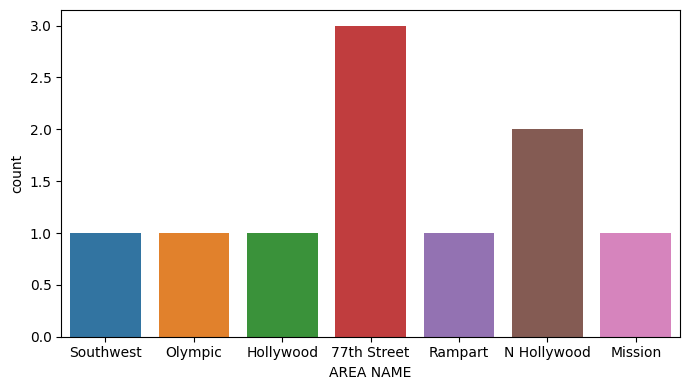

In [11]:
# EXTRA: Visualizing locations with high occurrence of crimes at night
plt.figure(figsize=(7,4))
sns.countplot(data=crimes_lapd.head(10), x="AREA NAME", hue="AREA NAME")
plt.tight_layout()

plt.show()

### Q - Identify the number of crimes committed against victims of different age groups
Save as a pandas Series called `victim_ages`, with **below age group labels as the index** and the **frequency of crimes as the values**:

"0-17", "18-25", "26-34", "35-44", "45-54", "55-64", and "65+" 

We'll try with `pd.cut` or  add an age_Category column using `np.select`

In [12]:
bins=[0, 17, 25, 34, 44, 54, 64, np.inf]
labels=["0-17","18-25","26-34","35-44","45-44","55-64","65+"]
vic_ages = pd.cut(x=crimes_lapd["Vict Age"], bins=bins, labels=labels, right=True)

In [13]:
crimes_lapd.insert(7, column="victim_ages",value=vic_ages)
crimes_lapd.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,victim_ages,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,220314085,2022-07-22,2020-05-12,11:10:00,Southwest,THEFT OF IDENTITY,27,26-34,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,222013040,2022-08-06,2020-06-04,16:20:00,Olympic,THEFT OF IDENTITY,60,55-64,M,H,NaN,Invest Cont,3300 SAN MARINO ST
2,220614831,2022-08-18,2020-08-17,12:00:00,Hollywood,THEFT OF IDENTITY,28,26-34,M,H,NaN,Invest Cont,1900 TRANSIENT
3,231207725,2023-02-27,2020-01-27,06:35:00,77th Street,THEFT OF IDENTITY,37,35-44,M,H,NaN,Invest Cont,6200 4TH AV
4,220213256,2022-07-14,2020-07-14,09:00:00,Rampart,THEFT OF IDENTITY,79,65+,M,B,NaN,Invest Cont,1200 W 7TH ST


In [14]:
# Now counting the no. of occurrences per victim age groups
victim_ages =  crimes_lapd["victim_ages"].value_counts()
victim_ages

victim_ages
26-34    47470
35-44    42157
45-44    28353
18-25    28291
55-64    20169
65+      14747
0-17      4528
Name: count, dtype: int64

In [17]:
crimes_lapd["Vict Age"].describe()

count    185715.000000
mean         39.999257
std          15.450227
min           2.000000
25%          28.000000
50%          37.000000
75%          50.000000
max          99.000000
Name: Vict Age, dtype: float64